# NN tryouts on SPR data, inspired by Kaggle Forum "When less is more"


- Load m month of data
- Minimal data cleaning
- Feature engineering

- Setup model

TRAIN : 201505, 201506

- FEATURES <- get_profile(ALL_FEATURES) : Select some profiles

- Train on all users
- Select only users that added products in 201506 comparing to 201505


month data is like [FEATURES|TARGETS]

X_train = [FEATURES] of the training part
Y_train = [TARGETS]  of the training part

X_val = [FEATURES] of the validation part
Y_val = [TARGETS]  of the validation part

TEST : 201606

- All users

[FEATURES]

X_test = [FEATURES]

In [1]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from common import load_data2, minimal_clean_data_inplace, preprocess_data_inplace, TARGET_LABELS
from common import get_added_products, remove_last_choice, apk, map7_score2

from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

In [3]:
TRAIN_FILE_PATH = os.path.join("..", "data", "train_ver2.csv")
TEST_FILE_PATH = os.path.join("..", "data", "test_ver2.csv")

Load data + minimal cleaning + preprocessing

* 201505 - to get the clients last choice 
* 201506 - to train on

In [4]:
yearmonth_list = [201505, 201506] 
nb_months = len(yearmonth_list)
#nb_clients = 250000
nb_clients = 'max'

In [5]:
data_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, nb_clients)
minimal_clean_data_inplace(data_df)
preprocess_data_inplace(data_df)

months = data_df['fecha_dato'].unique()
clients = data_df['ncodpers'].unique()
assert len(clients) == (data_df['ncodpers'].value_counts() == nb_months).sum()
ll = len(clients)
for m in months:
    l = len(data_df[data_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)

INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 3716
INFO:root:- Number of columns with nan : 10


In [6]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

last_choice_mask = data_df['fecha_dato'] == months[-2]
train_month_mask = data_df['fecha_dato'] == months[-1]

In [7]:
from common import PREPROCESS_LABEL_ENCODERS
#PREPROCESS_LABEL_ENCODERS

Create profiles and create models for profiles

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

Using Theano backend.


## Select only clients that choose new products in 201506 comparing with 201505

201505 [FEATURES|TARGETS]  
201506 [FEATURES|TARGETS]  

TARGETS_201505 -> clients_last_choice
TARGETS_201506 - TARGETS_201505 -> active_clients

Cross-validation : 
FEATURES_201506 -> (Split train/val) :
  --> (0.75*FEATURES) -> (select only active clients) -> X_train
  --> 0.25*FEATURES -> X_val



In [9]:
trainval_df = data_df.sort_values(['fecha_dato', 'ncodpers'])
last_choice_mask = trainval_df['fecha_dato'] == months[-2]
train_month_mask = trainval_df['fecha_dato'] == months[-1]

In [10]:
def add_diff_inplace(df, last_choice_mask, train_month_mask):
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'target'] = df[TARGET_LABELS].sum(axis=1)
    v1 = tmp_df[train_month_mask]['target'].values
    v2 = tmp_df[last_choice_mask]['target'].values
    ll = min(len(v1), len(v2))
    indices = tmp_df.index[ll:]
    df.loc[indices,'diff'] = pd.Series(v1 - v2, index=indices)
    del tmp_df, v1, v2

In [11]:
add_diff_inplace(trainval_df, last_choice_mask, train_month_mask)
print trainval_df.shape

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(1253490, 47)


In [12]:
clients_last_choice = trainval_df[last_choice_mask][['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
X = trainval_df[train_month_mask][['ncodpers', 'diff'] + features]
Y = trainval_df[train_month_mask][['ncodpers'] + TARGET_LABELS]

In [13]:
# Select only clients from test data
clients_last_choice = clients_last_choice[clients_last_choice['ncodpers'].isin(X['ncodpers'])]
assert (X['ncodpers'].values == clients_last_choice['ncodpers'].values).all(), "WTF"

### Feature engineering

In [14]:
def get_age_group_index(age):
    if age < 10:
        return -3
    elif age < 15:
        return -2        
    elif age < 18:
        return -1    
    elif age < 23:
        return 0
    elif age < 25:
        return 1
    elif age < 27:
        return 2
    elif age < 28:
        return 3    
    elif age < 32:
        return 4
    elif age < 37:
        return 5    
    elif age < 42:
        return 6
    elif age < 47:
        return 7
    elif age < 52:
        return 8
    elif age < 57:
        return 9
    elif age < 60:
        return 10
    elif age < 65:
        return 11
    elif age < 70:
        return 12
    elif age < 75:
        return 13
    elif age < 80:
        return 14
    else:
        return 15

def get_income_group_index(income):
    if income < 0:
        return -1
    elif income < 45542.97:
        return 1
    elif income < 57629.67:
        return 2
    elif income < 68211.78:
        return 3
    elif income < 78852.39:
        return 4
    elif income < 90461.97:
        return 5
    elif income < 103855.23:
        return 6
    elif income < 120063.00:
        return 7
    elif income < 141347.49:
        return 8
    elif income < 173418.36:
        return 9
    elif income < 234687.12:
        return 10
    else:
        return 11

In [15]:
X.loc[:,'age'] = X['age'].apply(get_age_group_index)
X.loc[:,'renta'] = X['renta'].apply(get_income_group_index)

In [16]:
# mask = X['diff'] > 0
# plt.figure(figsize=(12,6))
# plt.subplot(221)
# X[mask]['age'].hist(bins=17)
# plt.subplot(222)
# X[mask]['renta'].hist(bins=13)
# plt.subplot(223)
# X['age'].hist(bins=17)
# plt.subplot(224)
# X['renta'].hist(bins=13)

In [17]:
def separate_by(x_df, y_df, clc_df, feature, values):
    """
    return X_0, Y_0, CLC_0, X_1, Y_1, CLC_1
    0 - others
    1 - selected by `feature` within `values`
    """
    mask = x_df[feature].isin(values) 
    mask_clients = x_df[mask]['ncodpers']
    x_1 = x_df[mask]
    y_1 = y_df[mask]
    x_0 = x_df[~mask]
    y_0 = y_df[~mask]
    mask = clc_df['ncodpers'].isin(mask_clients)
    clc_1 = clc_df[mask]
    clc_0 = clc_df[~mask]
    return x_0, y_0, clc_0, x_1, y_1, clc_1

Separate young people from other due to different train/val distributions

In [18]:
X_0, Y_0, clients_last_choice_0, X_1, Y_1, clients_last_choice_1 = separate_by(X, Y, clients_last_choice, 'age', [0, 1, 2])

Separate clinets on Spain living people and other

In [19]:
X_00, Y_00, clients_last_choice_00, X_01, Y_01, clients_last_choice_01 = separate_by(X_0, Y_0, clients_last_choice_0, 'pais_residencia', [0])
X_10, Y_10, clients_last_choice_10, X_11, Y_11, clients_last_choice_11 = separate_by(X_1, Y_1, clients_last_choice_1, 'pais_residencia', [0])

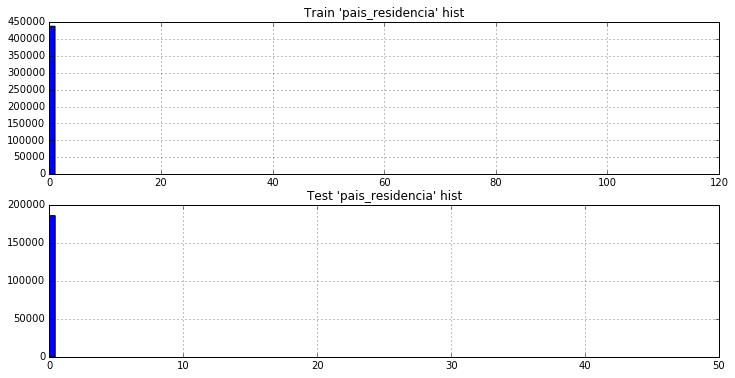

In [20]:
visualize_train_test(X_0, X_1, ['pais_residencia'])

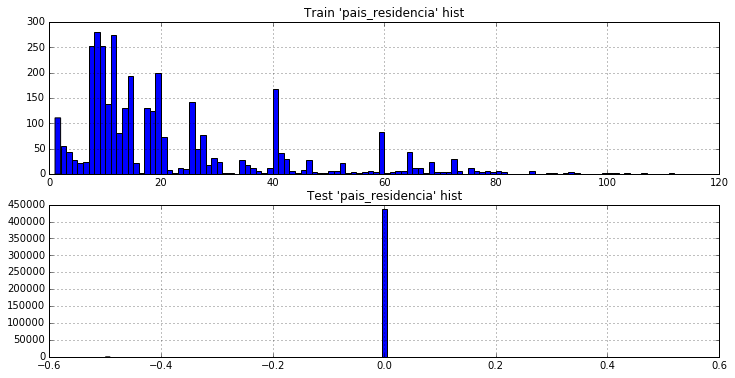

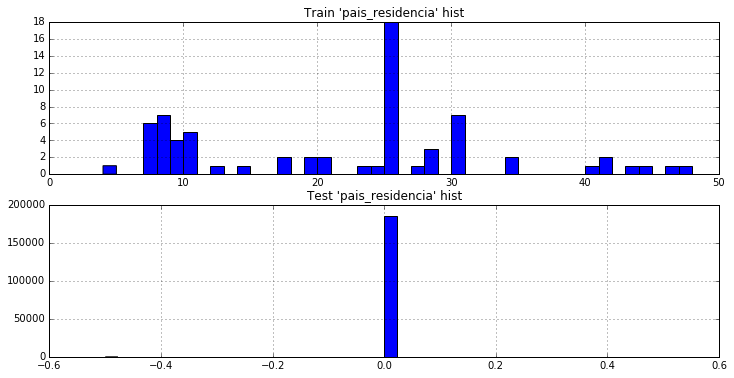

In [21]:
visualize_train_test(X_00, X_01, ['pais_residencia'])
visualize_train_test(X_10, X_11, ['pais_residencia'])

### Run KFold Cross-validation 

In [22]:
def create_model(profiles):
    ll = len(TARGET_LABELS)
    final_model = Sequential()
    models = []
    for key in profiles:
        length = len(profiles[key])
        model = Sequential()
        model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(10 + length, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(ll, activation='sigmoid'))
        models.append(model)

    merged = Merge(models, mode='ave')
    final_model.add(merged)
    final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [23]:
from sklearn.model_selection import KFold

nb_folds=3

def max_map7_score_per_fold(x_df, y_df, clients_last_choice_df, nb_folds):    
    kf = KFold(n_splits=nb_folds)
    scores = []
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_val = x_df.loc[x_df.index[test_index], :]
        Y_val = y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]                
        x_val, y_val = prepare_to_test(X_val, Y_val)
        scores.append(map7_score2(y_val, y_val, CLC_val[TARGET_LABELS].values))  
    return scores
        
#visualize_folds(X_0, 5, other_profiles[0], Y_0)
#visualize_folds(X_1, 5, young_profiles[0], Y_1)
#max_map7_score_per_fold(X_1, Y_1, clients_last_choice, 5)

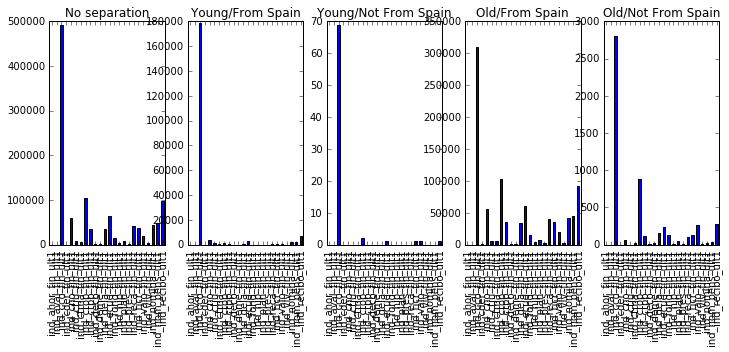

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.title("No separation")
Y[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(152)
plt.title("Young/From Spain")
Y_11[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(153)
plt.title("Young/Not From Spain")
Y_10[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(154)
plt.title("Old/From Spain")
Y_01[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(155)
plt.title("Old/Not From Spain")
Y_00[TARGET_LABELS].sum(axis=0).plot.bar()

In [26]:
# CROSS VALIDATION
from sklearn.preprocessing import StandardScaler
n_highest = 7

# def dummies_to_decimal(row):
#     output = ''
#     for v in row.values:
#         output += str(int(v))
#     return log(int(output,2)+1)

def prepare_to_fit(X_train, Y_train, profiles):
    # Select only active client for the training part
    mask = X_train['diff'] > 0
    X_train_ = X_train[mask]
    y_train = Y_train[mask][TARGET_LABELS].values
    
    x_train = []
    for key in profiles:
        x_train_ = X_train_[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_fit_nomask(X_train, Y_train, profiles):
    y_train = Y_train[TARGET_LABELS].values
    x_train = []
    for key in profiles:
        x_train_ = X_train[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_test(X_val, profiles, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = []
    for key in profiles:
        x_val_ = X_val[profiles[key]].values    
        x_val_ = StandardScaler().fit_transform(x_val_)  
        x_val.append(x_val_)    
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val

def cross_val_score2(data, 
                     profiles,
                     nb_folds=5, 
                     prepare_to_fit_func=prepare_to_fit, 
                     prepare_to_test_func=prepare_to_test, 
                     create_model_func=create_model):
    
    x_df, y_df, clients_last_choice_df = data
    kf = KFold(n_splits=nb_folds)
    scores = []
    
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]
                
        x_train, y_train = prepare_to_fit_func(X_train, Y_train, profiles)
        x_val, y_val = prepare_to_test_func(X_val, profiles, Y_val)
        
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(
                [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
                [i.shape for i in x_val] if isinstance(x_val, list) else x_val.shape, 
                y_train.shape, 
                y_val.shape)
        )                
            
        logging.info("- Create the model : profiles={}".format(profiles))
        estimator = create_model_func(profiles)
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=2000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        y_pred = estimator.predict(x_val, verbose=0)
        logging.info("- Compute map7 score")
        scores.append(map7_score2(y_val, y_pred, CLC_val[TARGET_LABELS].values))        
    
    return np.array(scores)

- `00` - senior, not living in Spain
- `01` - senior, living in Spain
- `10` - young, not living in Spain
- `11` - young, living in Spain

In [27]:
profiles_10 = {
    0: ['renta', 'nomprov', 'ind_actividad_cliente', 'antiguedad'],
    1: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
}

profiles_11 = {
    0: ['renta', 'nomprov', 'ind_actividad_cliente', 'antiguedad'],
    1: ['sexo', 'age', 'segmento', 'renta'],
}


profiles_00 = {
      0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],

#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],

     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
    
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
      11: ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

profiles_01 = {
      0: ['sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],

#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],

     8: ['sexo', 'age', 'segmento', 'renta'],
    
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
      11: ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


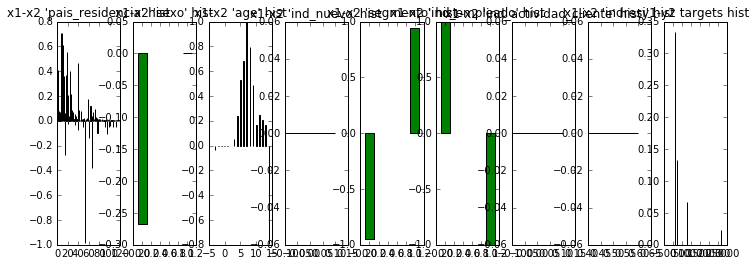

In [28]:
compare_two_datasets(X_00, X_10, profiles_00[0], Y_00, Y_10)

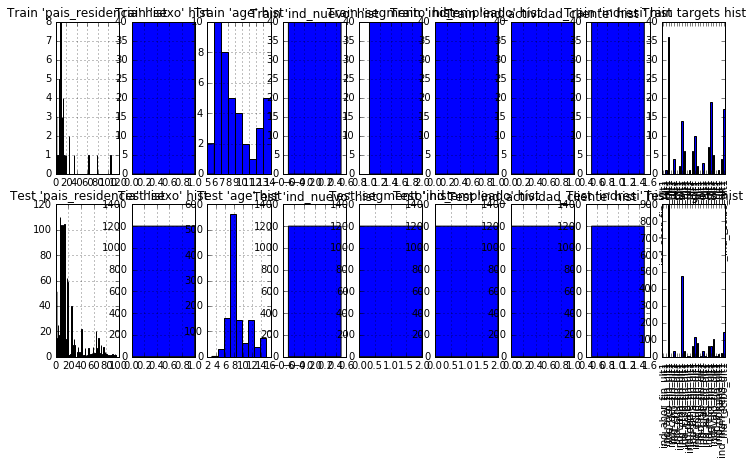

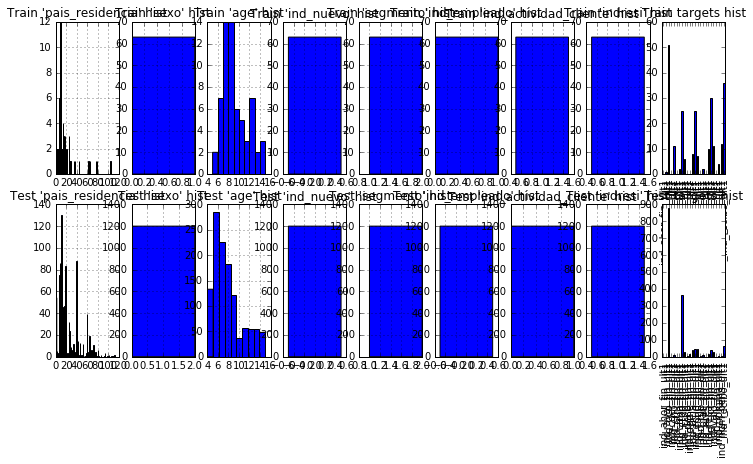

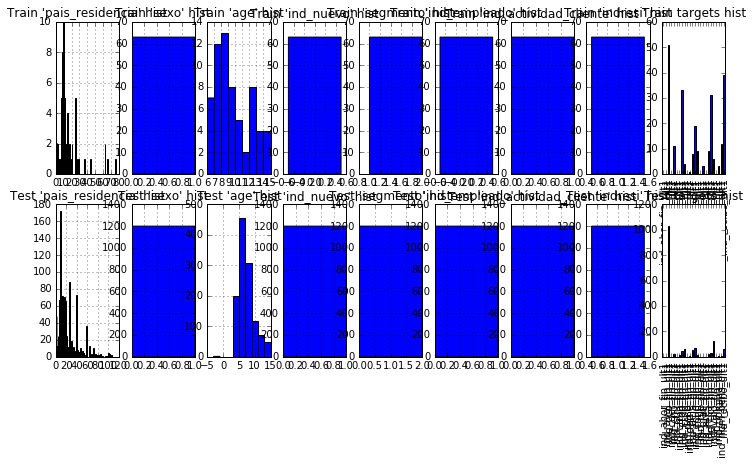

In [29]:
visualize_folds(X_00, 3, profiles_00[0], Y_00)

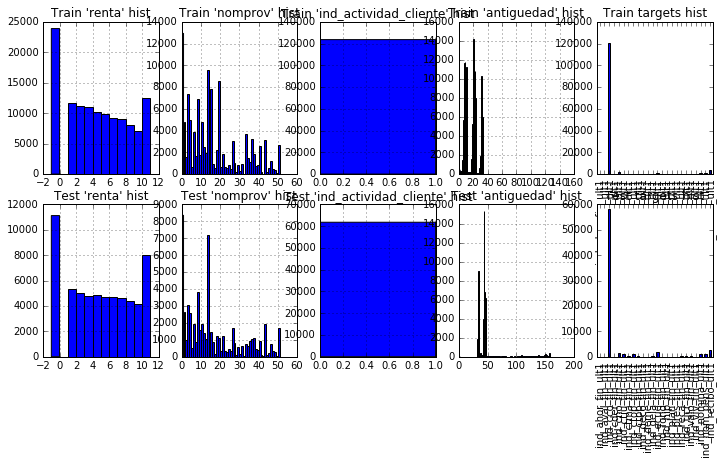

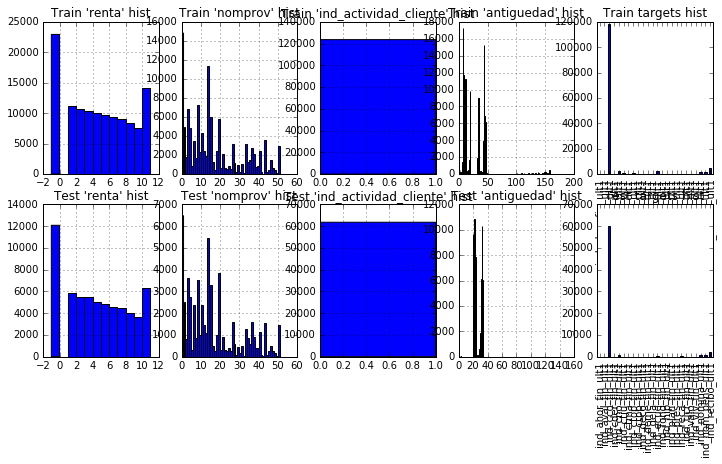

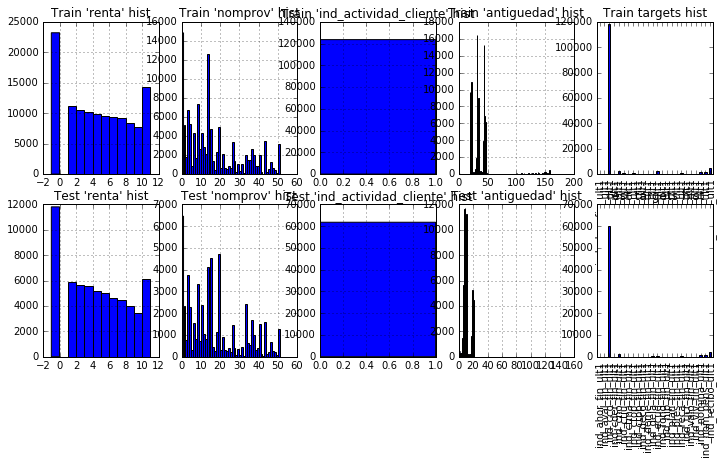

In [32]:
#visualize_folds(X_1, 3, young_profiles[0], Y_1)
visualize_folds(X_11, 3, profiles_11[0], Y_11, False)

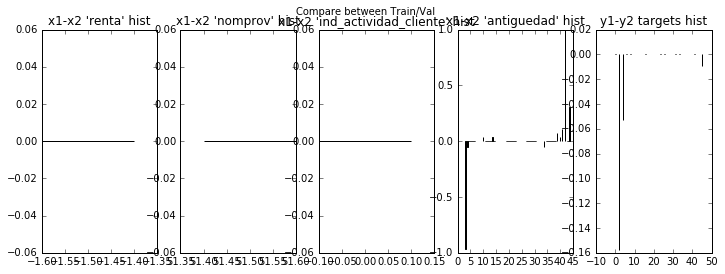

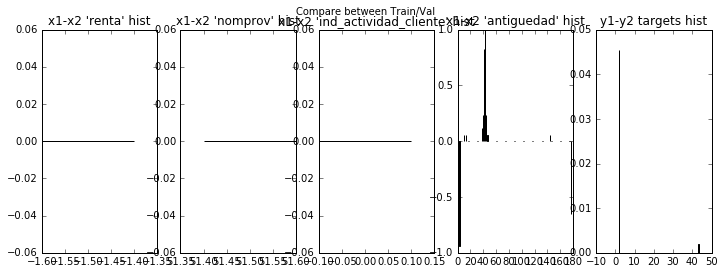

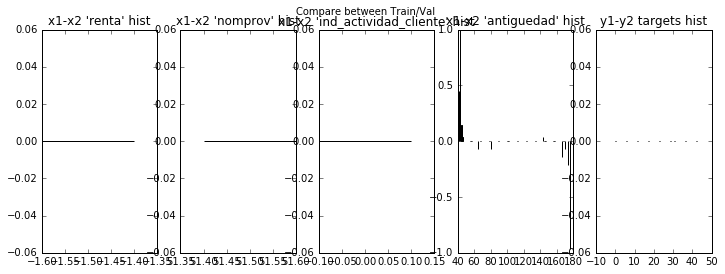

In [34]:
compare_folds(X_10, 3, profiles_10[0], Y_10, False)

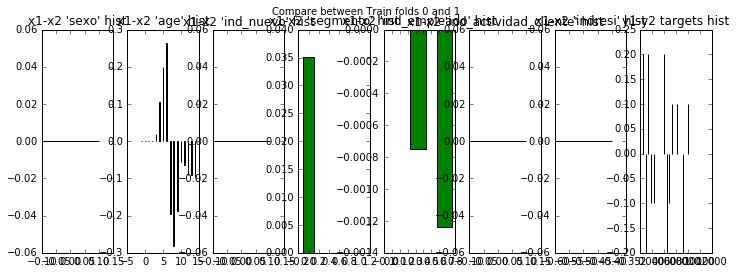

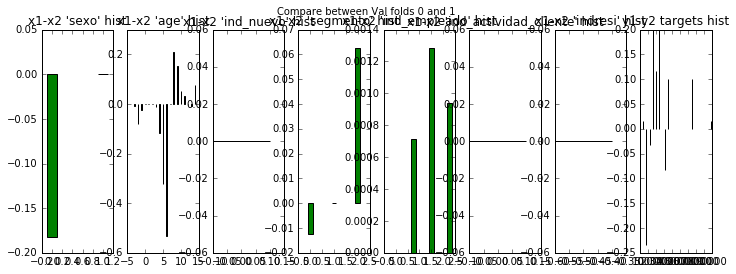

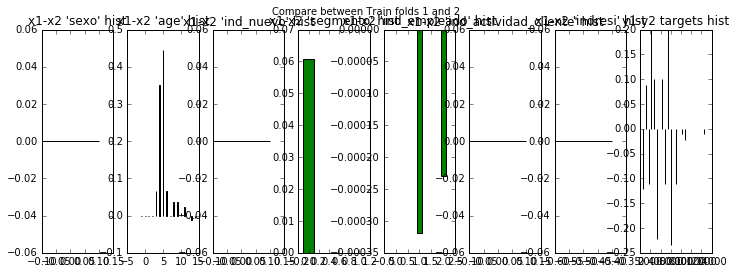

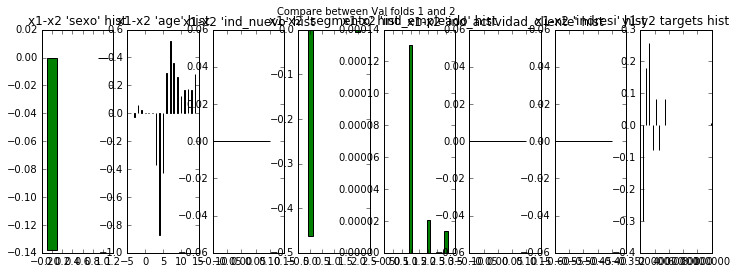

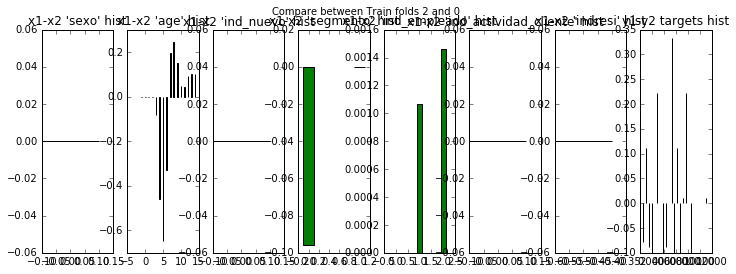

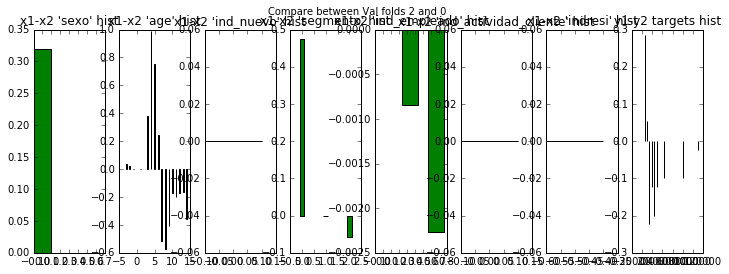

In [35]:
compare_folds2(X_01, 3, profiles_01[0], Y_01)

In [36]:
results = cross_val_score2((X_01, Y_01, clients_last_choice_01), 
                           profiles_01,
                           nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
INFO:root:- Train/Val shapes : [(14876, 7), (14876, 4), (14876, 5)], [(145855, 7), (145855, 4), (145855, 5)] | (14876, 24), (145855, 24)
INFO:root:- Create the model : profiles={0: ['sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'], 8: ['sexo', 'age', 'segmento', 'renta'], 11: ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada']}
INFO:root:- Fit the model
INFO:root:-- acc : min=0.636030, max=0.868874
INFO:root:-- loss : min=0.268996, max=0.689098
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0391195512177
INFO:root:- Train/Val shapes : [(17435, 7), (17435, 4), (17435, 5)], [(145855, 7), (145855, 4), (145855, 5)] | (17435, 24), (145855, 24)
INFO:root:- C

Cross-Validation 
 3 | 0.030903 | 0.038723 | 0.046148 | 0.00623 


In [143]:
results = cross_val_score2((X_00, Y_00, clients_last_choice_00), 
                           profiles_00,
                           nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Train/Val shapes : [(40, 8), (40, 5), (40, 5)], [(1201, 8), (1201, 5), (1201, 5)] | (40, 24), (1201, 24)
INFO:root:- Create the model : profiles={0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'], 8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'], 11: ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada']}
INFO:root:- Fit the model
INFO:root:-- acc : min=0.520833, max=0.915625
INFO:root:-- loss : min=0.208632, max=0.692901
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0262975298362
INFO:root:- Train/Val shapes : [(63, 8), (63, 5), (63, 5)], [(1201, 8), (1201, 5), (1201, 5)] | (63, 24), (1201, 24)
INFO:root:- Create the model : profiles={0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'], 8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'], 11: ['nomp

Cross-Validation 
 3 | 0.010783 | 0.017088 | 0.026298 | 0.00666 


In [146]:
results = cross_val_score2((X_10, Y_10, clients_last_choice_10), 
                           profiles_10,
                           #prepare_to_fit_func=prepare_to_fit_nomask,
                           nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by StandardScaler.

In [ ]:
results = cross_val_score2((X_11, Y_11, clients_last_choice_11), 
                           profiles_11,
                           #prepare_to_fit_func=prepare_to_fit_nomask,
                           nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

### Test 4 : Train on active clients + feature engineering


#### Data: (encoding bug fixed)

- yearmonth_list = [201505, 201506]
- nb_clients = 250000

#### Feature engineering

- age -> age group
- income -> income group
- separate young clients from others due to different train/test distributions


#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 

**Conf:**
- batch_size=2000

*Cross-validation results :* 

type | profiles | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | --- | --- | ---
other selected | other | 150 | 3 | 0.030828 | 0.039420 | 0.046891 | 0.00661 
young all | young | 150 | 3 | 0.011685 | 0.014247 | 0.017407 | 0.00237 
young all | other | 150 | 3 | 0.012589 | 0.014744 | 0.017384 | 0.00199
young selected | young | 150 | 3 | 0.012253 | 0.014514 | 0.017212 | 0.00205 
other all | other | 150 | 3 | 0.024697 | 0.030715 | 0.036805 | 0.00494 



**Conf:**
- batch_size=2000

*Cross-validation results :* 

type | profiles | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | --- | --- | ---
other selected | other | 150 | 5 | 0.032313 | 0.040522 | 0.054216 | 0.00972
other selected | young | 150 | 5 | 0.031943 | 0.039865 | 0.052624 | 0.00896 
young selected | young | 150 | 5 | 0.011029 | 0.014174 | 0.018775 | 0.00253 
young selected | other | 150 | 5 | 0.010593 | 0.013412 | 0.017140 | 0.00217 





#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000

#### Feature engineering

- age -> age group
- income -> income group
- separate young clients from others due to different train/test distributions


#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- batch_size=2000

*Cross-validation results :* 

On the others

type | profiles | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | --- | --- | ---
other | other | 150 | 5 | 0.030910 | 0.040277 | 0.056534 | 0.01018 
other | young | 150 | 5 | 0.030285 | 0.038983 | 0.052295 | 0.00880
young | young | 150 | 5 | 0.011273 | 0.014734 | 0.021766 | 0.00387 




### Test 3 : Train on active clients

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = max

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
--- | --- | --- | --- | --- | ---
150 | 5 | 0.021769 | 0.030416 | 0.041625 | 0.00679 



#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030864 | 0.00731


**Conf:**
- Profiles : 0, 8 
- batch_size=500

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030895 | 0.00732
500 | 5 | 0.030959 | 0.00776


**Conf:**
- Profiles : 0, 8 
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030885 | 0.00758
500 | 5 | 0.030639 | 0.00769



In [ ]:
## young_profile = ['pais_residencia', 'sexo', 'nomprov', 'renta', 'ind_actividad_cliente', 'canal_entrada']
# young_profile = ['renta', 'nomprov', 'ind_actividad_cliente']

# def prepare_to_fit2(X_train, Y_train):
#     # Select only active client for the training part
#     mask = X_train['diff'] > 0
#     X_train_ = X_train[mask]
#     y_train = Y_train[mask][TARGET_LABELS].values    
    
#     x_train = X_train_[young_profile].values
#     x_train = StandardScaler().fit_transform(x_train)
#     return x_train, y_train

# def prepare_to_fit3(X_train, Y_train):
#     X_train_ = X_train
#     y_train = Y_train[TARGET_LABELS].values    
    
#     x_train = X_train_[young_profile].values
#     x_train = StandardScaler().fit_transform(x_train)
#     return x_train, y_train


# def prepare_to_test2(X_val, Y_val=None):
#     if Y_val is not None:
#         y_val = Y_val[TARGET_LABELS].values
    
#     x_val = X_val[young_profile].values    
#     x_val = StandardScaler().fit_transform(x_val)  
    
#     if Y_val is not None:
#         return x_val, y_val
#     else:
#         return x_val


# def create_model2():
#     ll = len(TARGET_LABELS)
#     length = len(young_profile)
#     final_model = Sequential()
#     final_model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(40, activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(20, activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(ll, activation='sigmoid'))    
#     final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     return final_model

## Train model for predictions

In [39]:
def train_model(X_train, Y_train, profiles):

    x_train, y_train = prepare_to_fit(X_train, Y_train, profiles)
    logging.info("- Train data shapes : {}, {}".format(
            [i.shape for i in x_train], 
            y_train.shape)
    )                

    logging.info("- Create the model")
    estimator = create_model(profiles)
    logging.info("- Fit the model")
    hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=2000, verbose=0)        
    for key in hist.history:            
        logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
    return estimator

estimator_0 = train_model(X_0, Y_0, other_profiles)
estimator_1 = train_model(X_1, Y_1, young_profiles)

estimators = {
    0: {'estimator': estimator_0, 'profiles': other_profiles},
    1: {'estimator': estimator_1, 'profiles': young_profiles},
}

INFO:root:- Train data shapes : [(9291, 8), (9291, 5), (9291, 6)], (9291, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.661900, max=0.853828
INFO:root:-- loss : min=0.290040, max=0.687051
INFO:root:- Train data shapes : [(913, 4), (913, 5)], (913, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.464586, max=0.918492
INFO:root:-- loss : min=0.177084, max=0.694218


Check score on the same data

In [54]:
data = {
    0: {'x': X_0, 'y': Y_0, 'clc': clients_last_choice_0},
    1: {'x': X_1, 'y': Y_1, 'clc': clients_last_choice_1},
}

for i in range(2):
    x, y, clc = data[i]['x'], data[i]['y'], data[i]['clc']
    profiles = estimators[i]['profiles']
    estimator = estimators[i]['estimator']
    x_val, y_val = prepare_to_test(x, profiles, y)
    y_pred = estimator.predict(x_val, verbose=0)
    print "Score on the whole dataset : ", map7_score2(y_val, y_pred, clc[TARGET_LABELS].values)


Score on the whole dataset : 

INFO:root:-- Predicted map7 score: 0.0414416422177


 0.0414416422177
Score on the whole dataset : 

INFO:root:-- Predicted map7 score: 0.0144165785903


 0.0144165785903


## Prediction on test data

Load the last month from the training dataset to get user last choice and remove it from predictions

In [14]:
yearmonth_list = [201605]
lastmonth_df = load_data2(TRAIN_FILE_PATH, yearmonth_list)
minimal_clean_data_inplace(lastmonth_df)

test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)
preprocess_data_inplace(test_df)
test_df = test_df.sort_values(['ncodpers'])

clients_last_choice_test = lastmonth_df[['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
# Select only clients from test data
clients_last_choice_test = clients_last_choice_test[clients_last_choice_test['ncodpers'].isin(test_df['ncodpers'])]
assert (test_df['ncodpers'].values == clients_last_choice_test['ncodpers'].values).all(), "WTF"

INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10


In [15]:
X_test = test_df[['ncodpers'] + features]

In [23]:
X_test.loc[:,'age'] = X_test['age'].apply(get_age_group_index)
X_test.loc[:,'renta'] = X_test['renta'].apply(get_income_group_index)

In [ ]:
# plt.figure(figsize=(12,4))
# plt.subplot(121)
# X_test['age'].hist(bins=17)
# plt.subplot(122)
# X_test['renta'].hist(bins=13)

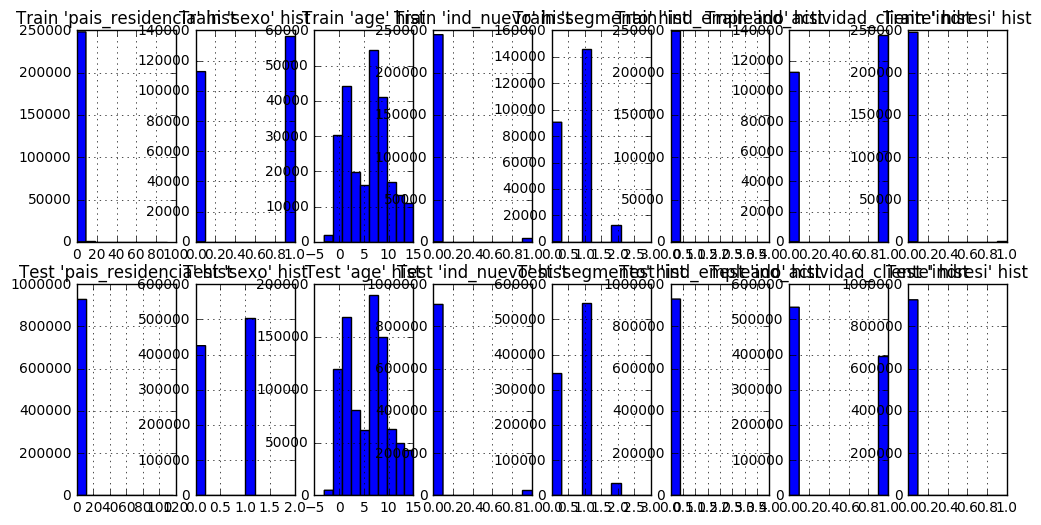

In [26]:
visualize_train_test(X, X_test, other_profiles[0])

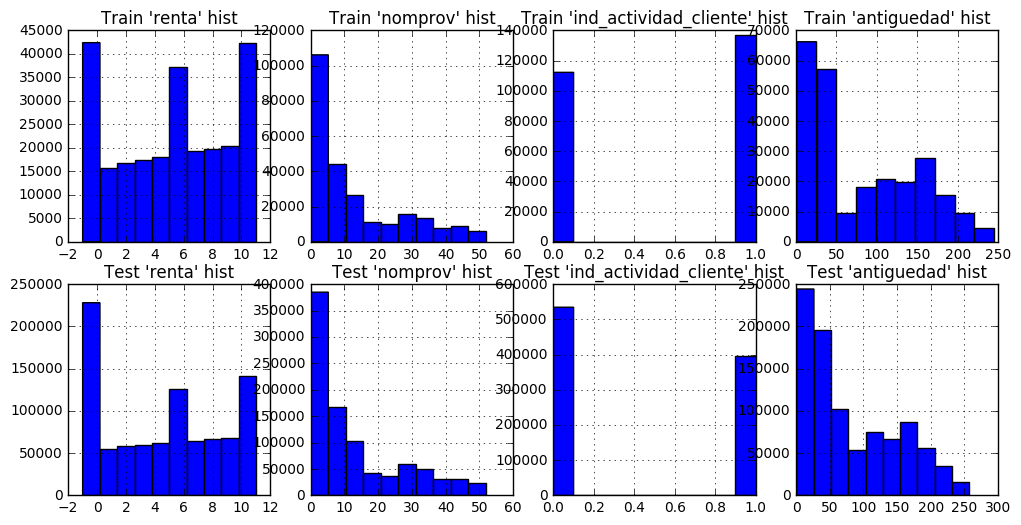

In [27]:
visualize_train_test(X, X_test, young_profiles[0])

In [64]:
#del X, Y, trainval_df, data_df
#del X_0, X_1, Y_0, Y_1, data

Separate young people from others 

In [28]:
mask = X_test['age'].isin([0, 1, 2]) 
mask_clients = X_test[mask]['ncodpers']
X_test_1 = X_test[mask]
X_test_0 = X_test[~mask]
mask = clients_last_choice_test['ncodpers'].isin(mask_clients)
clients_last_choice_test_1 = clients_last_choice_test[mask]
clients_last_choice_test_0 = clients_last_choice_test[~mask]

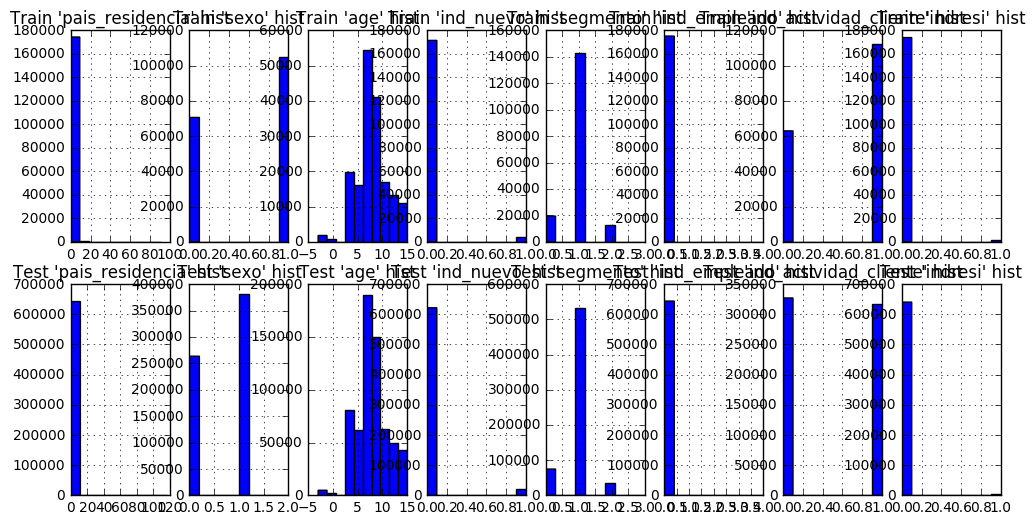

In [29]:
#visualize_train_test(X_0, X_test_0, np.array(other_profiles[0])[[0,5]])
#visualize_train_test(X_0, X_test_0, other_profiles[0])

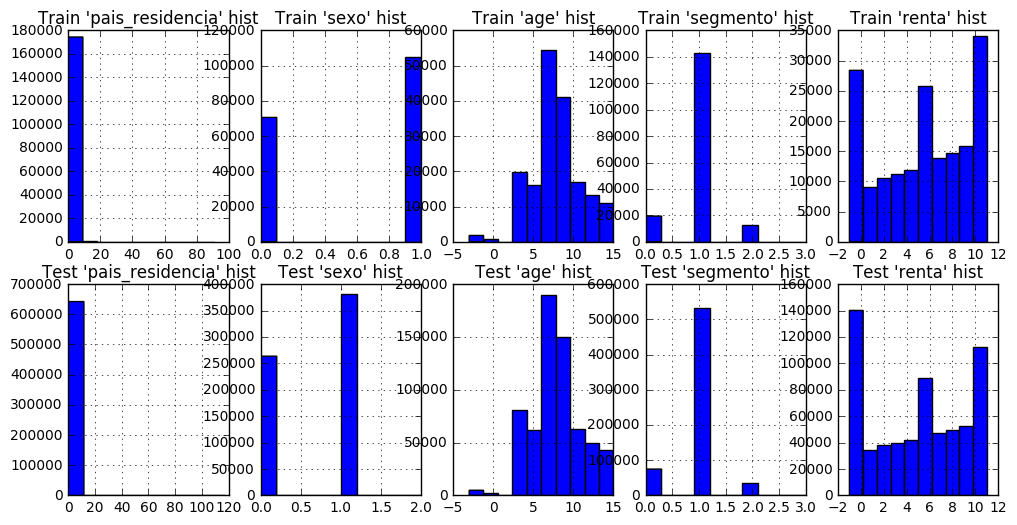

In [33]:
#visualize_train_test(X_0, X_test_0, other_profiles[8])

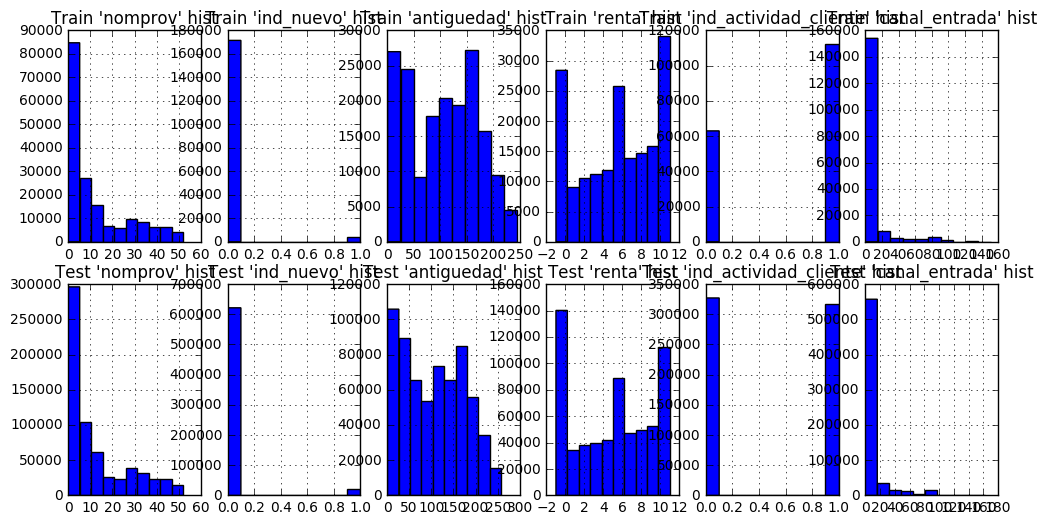

In [34]:
#visualize_train_test(X_0, X_test_0, other_profiles[11])

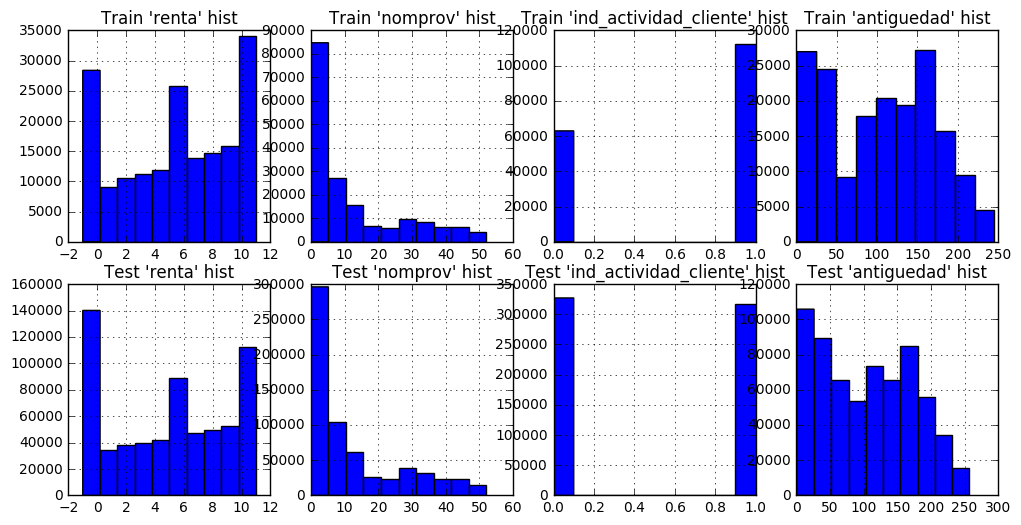

In [35]:
#visualize_train_test(X_0, X_test_0, young_profiles[0])

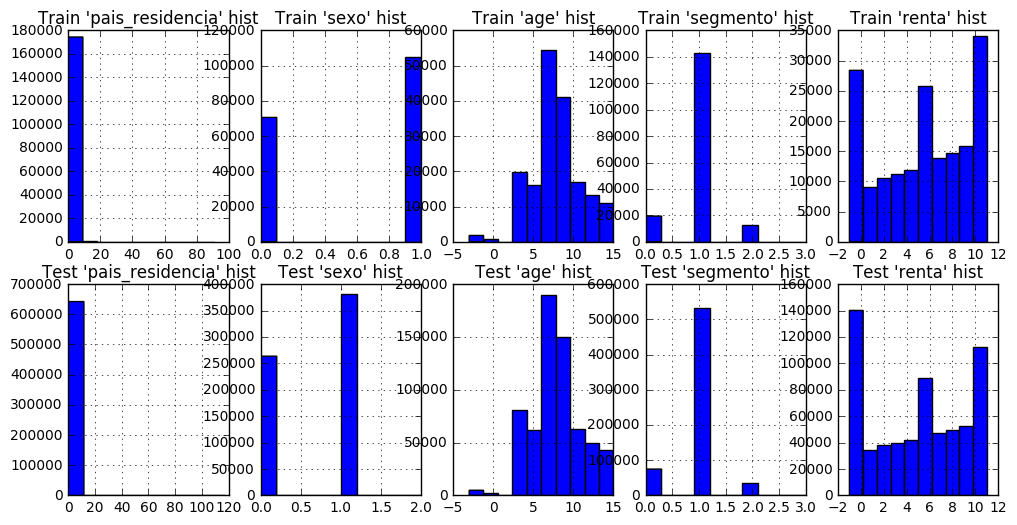

In [37]:
#visualize_train_test(X_0, X_test_0, young_profiles[8])

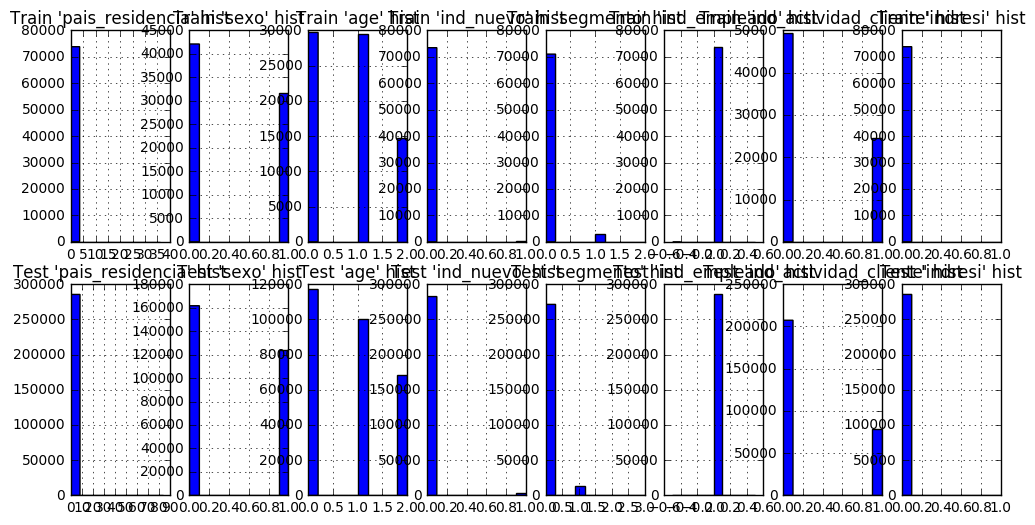

In [38]:
#visualize_train_test(X_1, X_test_1, other_profiles[0])

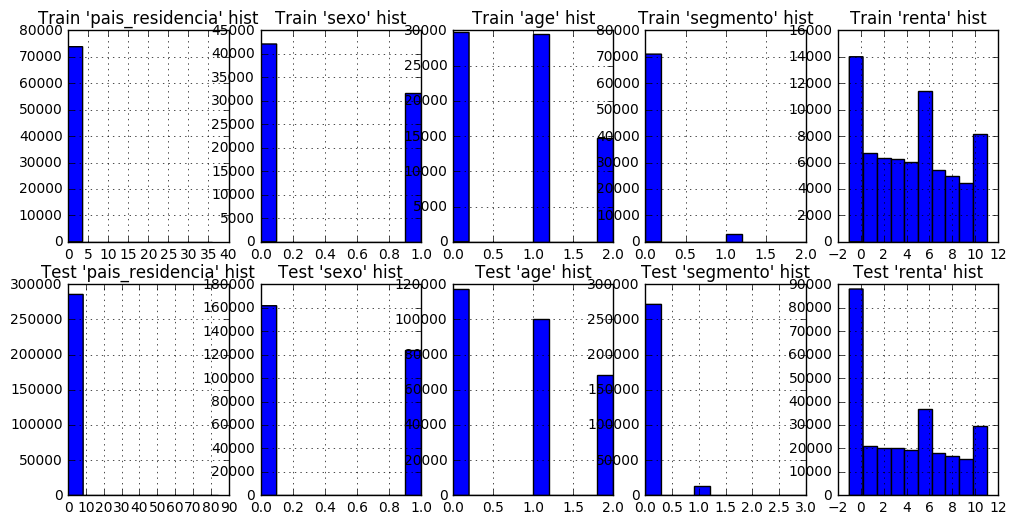

In [39]:
#visualize_train_test(X_1, X_test_1, other_profiles[8])

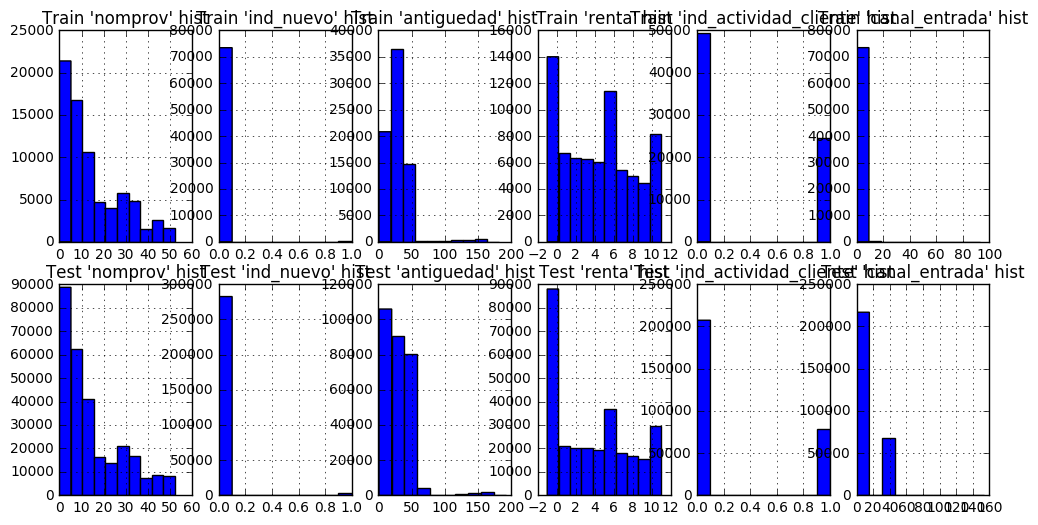

In [40]:
#visualize_train_test(X_1, X_test_1, other_profiles[11])

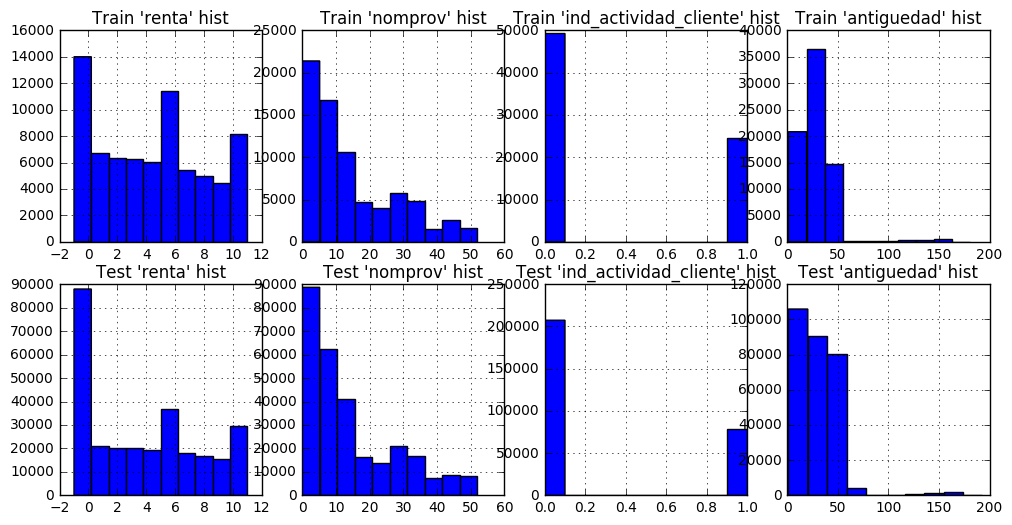

In [41]:
#visualize_train_test(X_1, X_test_1, young_profiles[0])

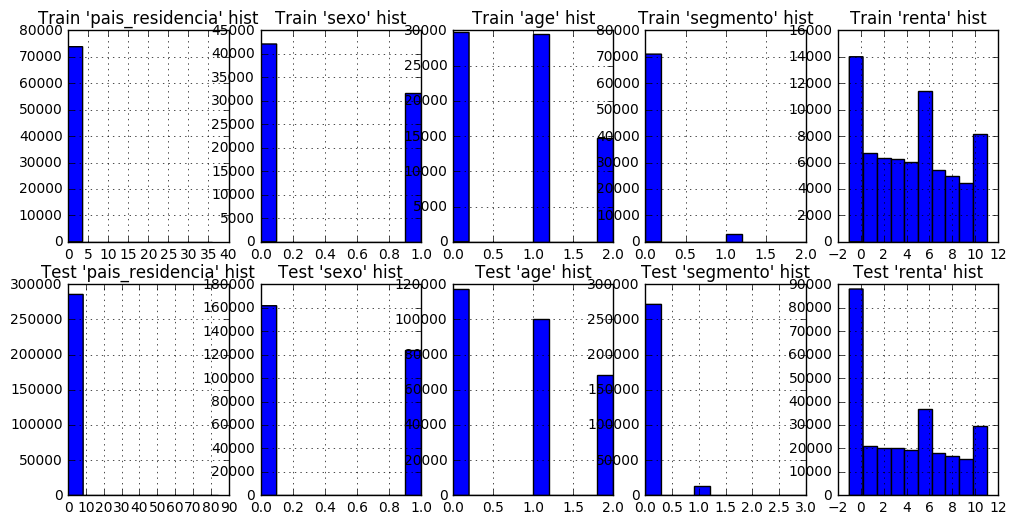

In [43]:
#visualize_train_test(X_1, X_test_1, young_profiles[8])

Make predictions

In [52]:
def get_submission(y_pred, clients, clc, target_labels, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [60]:

data = {
    0: {'x': X_test_0, 'clc': clients_last_choice_test_0},
    1: {'x': X_test_1, 'clc': clients_last_choice_test_1},
}

submissions = []
for i in range(2):
    x = data[i]['x']
    clc = data[i]['clc']
    p = estimators[i]['profiles']
    e = estimators[i]['estimator']
    x_test = prepare_to_test(x, p)
    y_pred = e.predict(x_test, verbose=0)

    clients = x['ncodpers']
    submission = get_submission(y_pred, clients, clc[TARGET_LABELS].values, TARGET_LABELS, 7)
    print submission.head()
    submissions.append(submission)

submission = pd.concat(submissions)

INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000
INFO:root:Elapsed : 300000
INFO:root:Elapsed : 400000
INFO:root:Elapsed : 500000
INFO:root:Elapsed : 600000


        ncodpers                                     added_products
0          15889  ind_recibo_ult1 ind_ecue_fin_ult1 ind_cno_fin_...
618359     15890                 ind_cco_fin_ult1 ind_reca_fin_ult1
618360     15892                 ind_cno_fin_ult1 ind_nom_pens_ult1
618361     15893  ind_recibo_ult1 ind_cno_fin_ult1 ind_nom_pens_...
618362     15894                                   ind_cno_fin_ult1


INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000


        ncodpers                                     added_products
636483     54315  ind_cco_fin_ult1 ind_recibo_ult1 ind_ecue_fin_...
693824    174986  ind_nom_pens_ult1 ind_recibo_ult1 ind_nomina_u...
686693    189104  ind_recibo_ult1 ind_nom_pens_ult1 ind_nomina_u...
663494    233706  ind_nom_pens_ult1 ind_nomina_ult1 ind_recibo_u...
490708    350768  ind_nom_pens_ult1 ind_nomina_ult1 ind_recibo_u...


In [61]:
submission.head()

,ncodpers,added_products
0,15889,ind_recibo_ult1 ind_ecue_fin_ult1 ind_cno_fin_...
618359,15890,ind_cco_fin_ult1 ind_reca_fin_ult1
618360,15892,ind_cno_fin_ult1 ind_nom_pens_ult1
618361,15893,ind_recibo_ult1 ind_cno_fin_ult1 ind_nom_pens_...
618362,15894,ind_cno_fin_ult1


Get submission DataFrame and write csv file

In [62]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

INFO:root:- Generate submission
